# Head

In [83]:
import numpy as np
import pandas as pd
import time
import serial
from matplotlib import pyplot as plt
from tqdm import tqdm
from os import listdir
import textwrap
%matplotlib widget

In [84]:
# from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import learning_curve, StratifiedKFold, LearningCurveDisplay
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
 
# Выявление аномалий
from pyod.models.hbos import HBOS

# Оптимизатор гиперпараметров
import optuna
from optuna_dashboard import save_note

from IPython.display import clear_output

In [85]:
''' 
+ Добавить метод склеивания датасетов 
+(1 метод) Добавить 2 метода разделения данных в Train-test split
Выявлять аномалии в датасете и как-то их обрабатывать
'''

' \n+ Добавить метод склеивания датасетов \n+(1 метод) Добавить 2 метода разделения данных в Train-test split\nВыявлять аномалии в датасете и как-то их обрабатывать\n'

In [86]:
# comet.ml data
API_KEY = ''
PROJECT_NAME = ''
WORKSPACE = ''
# do list
DO_CLEAR_ANOMALY = False # Очистка от аномалий
DO_DRAW_PLOTS = False # Построение графиков
DO_OPTUNA_SEARCH = False # Поиск гиперпараметров
DO_POLYNOMIAL_FEATURES = False # Полиномиальные признаки
DO_MMSCALER = True # Скалирование данных
DO_PLOT_LEARNING_CURVE = False # Нарисовать график кривой обучения
DO_OFFLINE_INFERENCE = True # Оффлайн проверка инференса
DO_ONLINE_INFERENCE = False # Онлайн проверка инференса
DO_LOG = False # Логирование 

In [87]:
try: print_report() 
except: pass

# IO utils


In [88]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

In [89]:
def print_report():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('='*25,'Train','='*25)
    print(classification_report(y_train, y_pred_train, target_names=GESTURES))
    print('='*25,'Test','='*25)
    print(classification_report(y_test, y_pred_test, target_names=GESTURES))

In [90]:
# Функция для рисования матрицы ошибок:
def draw_confusion_matrix(model,X,y):
    predictions = model.predict(X)
    cm = confusion_matrix(y, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )
    disp.plot();

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [91]:
# Список всех доступных датасетов
palms_list = ['./data/'+s for s in listdir('./data/') if s.__len__() == 24]

# Список индексов датасетов отсортированный по метрикам от худшего к лучшему
bad_data = [28, 5, 18, 2, 17, 27, 22, 16, 11, 20, 3, 19, 14, 26, 12, 21, 1, 23, 15, 13, 24, 4, 25, 9, 10, 7, 6, 8, 0]
bad_data = bad_data[:12] # Отбираем худшие датасеты

# Новый список датасетов отсеиный от плохих
new_list = []
for i, file in enumerate(palms_list): # Цикл по всем датасетам
    if not i in bad_data: # Если индекс есть в списке плохих датасетов, то не добавляем его в новый список
        new_list.append(file)
palms_list = new_list
palms_list

['./data/2023-05-05_17-57-30.palm',
 './data/2023-05-07_15-19-05.palm',
 './data/2023-05-15_16-16-08.palm',
 './data/2023-05-19_12-04-02.palm',
 './data/2023-05-22_17-04-29.palm',
 './data/2023-05-22_20-22-01.palm',
 './data/2023-05-31_15-46-37.palm',
 './data/2023-05-31_17-14-41.palm',
 './data/2023-06-05_17-53-01.palm',
 './data/2023-06-20_12-34-17.palm',
 './data/2023-06-20_13-30-15.palm',
 './data/2023-06-20_14-43-11.palm',
 './data/2023-09-30_08-06-44.palm',
 './data/2023-10-18_11-16-21.palm',
 './data/2023-10-23_10-11-45.palm',
 './data/2023-10-23_14-07-13.palm',
 './data/2023-10-23_16-23-02.palm']

In [92]:
# Датасет с метаинформацией про данные также отсеянный от плохих датасетов
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta = df_meta[df_meta['montage'].isin([s[7:] for s in palms_list])] # Оставляем только те файлы что есть в списке допущенных
df_meta

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441
5,2023-06-20_13-30-15.palm,1,17928,17928,4435
6,2023-06-20_12-34-17.palm,1,17758,17758,4444
7,2023-09-30_08-06-44.palm,2,5693,5693,5509
13,2023-05-31_17-14-41.palm,2,15679,15679,3891
14,2023-05-31_15-46-37.palm,2,15676,15676,3892
15,2023-05-22_20-22-01.palm,2,15602,15602,3872
16,2023-05-22_17-04-29.palm,2,23289,23289,5796


In [93]:
def get_palm_files(get_type='all',var=None): # Выбираем файлы
    """Отобрать конкретные файлы

    Args:
        get_type ('all','id', optional): По какой логике отобрать. Defaults to 'all'.
        var (int, optional): Служебная переменная. Defaults to None.

    Returns:
        list: Список отобранных файлов
    """    
    if get_type == 'all': # Выбираем все доступные файлы
        palm_files = df_meta['montage'].values
    elif get_type == 'pilot_id': # Выбираем по пилоту
        palm_files = df_meta[df_meta['pilote_id'] == var]['montage'].values
    elif get_type == 'id':
        palm_files = [df_meta.loc[var]['montage']]
    
    palm_files = ['./data/'+s for s in palm_files]
    
    return palm_files

In [94]:
#palm_files = get_palm_files(get_type='id',var=3)
palm_files = get_palm_files()#[9:15]
palm_files = get_palm_files(get_type='all',var=2)[10:14]
palm_files

['./data/2023-05-19_12-04-02.palm',
 './data/2023-05-07_15-19-05.palm',
 './data/2023-05-05_17-57-30.palm',
 './data/2023-10-23_16-23-02.palm']

In [95]:
def read_X(palm_files):
    data_list = []
    for palm_file in palm_files:
        data_list.append(read_omg_csv(palm_file, 
                                  n_omg_channels=50,
                                  n_acc_channels=3, 
                                  n_gyr_channels=3, 
                                  n_enc_channels=6, 
                                  n_mag_channels=0))
    X = pd.concat(data_list)
    return X

In [96]:
gestures = read_X(palm_files)
print(gestures.shape)
gestures.head()

(78149, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,83,3,4,201,74,2336,16,2074,177,2562,...,-8,0,0,0,0,0,0,1000,0,6668
1,88,0,2,206,85,2344,22,2076,184,2573,...,-7,0,0,0,0,0,0,1000,0,6701
2,86,0,1,204,66,2347,26,2084,184,2577,...,-6,0,0,0,0,0,0,1000,0,6734
3,78,2,0,194,48,2338,12,2077,175,2571,...,-6,0,0,0,0,0,0,1000,0,6767
4,89,1,4,206,70,2346,22,2084,184,2572,...,-6,0,0,0,0,0,0,1000,0,6800


In [97]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [98]:
# Списки с названиями признаков
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']

ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
# Проверка что списки нужной длины
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

ALL_CH = OMG_CH + ACC_CH + GYR_CH

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Anomaly detection

In [99]:
if DO_DRAW_PLOTS:
    fig, axx = plt.subplots(1, 1, sharex=True, figsize=(10, 5))
    
    plt.sca(axx)
    plt.plot(gestures[OMG_CH].values)
    plt.grid()
    plt.title('OMG_CH')
    plt.suptitle('OMG')
    plt.tight_layout()

In [100]:
if DO_CLEAR_ANOMALY:
    CLF_OMG_CH = [str(i)+'_clf' for i in range(50)]
    
    def clear_anomaly(df, contamination=0.05):
        '''Очистка датасета от аномалий методом HBOS библиотеки pyod, выявление аномалий по каждой колонке отдельно'''
        df = df.copy()
        clf = HBOS(contamination=contamination)
        df[CLF_OMG_CH] = df[OMG_CH]
        for column in CLF_OMG_CH: # Цикл по всем колонкам
            clf.fit(df[[column]])
            anomaly_scores = clf.predict(df[[column]])
            for i, val in enumerate(anomaly_scores):
                if val == 1: # Если текущее значение аномалия
                    if i == 0:
                        df.loc[i,column] = df.loc[i,column]
                    else:
                        df.loc[i,column] = df.loc[i-1,column]
        return df[CLF_OMG_CH]
    
    gestures[CLF_OMG_CH] = clear_anomaly(gestures[OMG_CH])

In [101]:
if DO_DRAW_PLOTS:
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
    plt.sca(axx[0])
    plt.plot(gestures[OMG_CH].values)
    plt.title('OMG_CH')
    plt.grid()
    
    plt.sca(axx[1])
    plt.plot(gestures[CLF_OMG_CH].values)
    plt.grid()
    plt.title('CLF_OMG_CH')
    
    plt.tight_layout()

### OMG_CH

In [102]:
if DO_DRAW_PLOTS:
    # График показаний датчиков
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[OMG_CH].values)
    plt.title('OMG')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### ACC GYR

In [103]:
if DO_DRAW_PLOTS:
    # График показаний акселерометров
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[ACC_CH].values)
    plt.title('ACC')
    plt.xlabel('Timesteps')
    plt.tight_layout()

In [104]:
if DO_DRAW_PLOTS:
    # График показаний гироскопов
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[GYR_CH].values)
    plt.title('GYR')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### Protocol

In [105]:
def read_y(palm_files):
    data_list = []
    for palm_file in palm_files:
        data_list.append(pd.read_csv(f'{palm_file}.protocol.csv', index_col=0))
    y = pd.concat(data_list)
    return y

In [106]:
# Целевые признаки сгибаний и разгибаний пальцев руки
gestures_protocol = read_y(palm_files)
print(gestures_protocol.shape)
gestures_protocol.head()

(760, 13)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation,Flexion,Extension
epoch,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN


In [107]:
def encode_y(y):
    # Перекодируем 10 признаков в 1 целевой признак 
    le = LabelEncoder()

    # FIT
    le.fit(
        y[[
            #'Pronation',
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )
    # TRANSFORM
    y['gesture'] = le.transform(
        y[[
            #'Pronation',
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )
    #display(np.c_[le.transform(le.classes_), le.classes_])
    return y
# Оказалось только 6 уникальных комбинаций сгибаний и растягиваний пальцев

In [108]:
y_cmd = encode_y(gestures_protocol)
y_cmd.head()

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation,Flexion,Extension,gesture
epoch,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,3
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,1


In [109]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [110]:
# Жесты в разные эпохи, 1 эпоха = 1 жест
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 760, dtype: int32

In [111]:
# Расширенный целевой признак
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
y_cmd = np.array([gestures_protocol['gesture'].iloc[s] for s in gestures['SYNC'].values]).flatten()
print(y_cmd.shape)

(78149,)


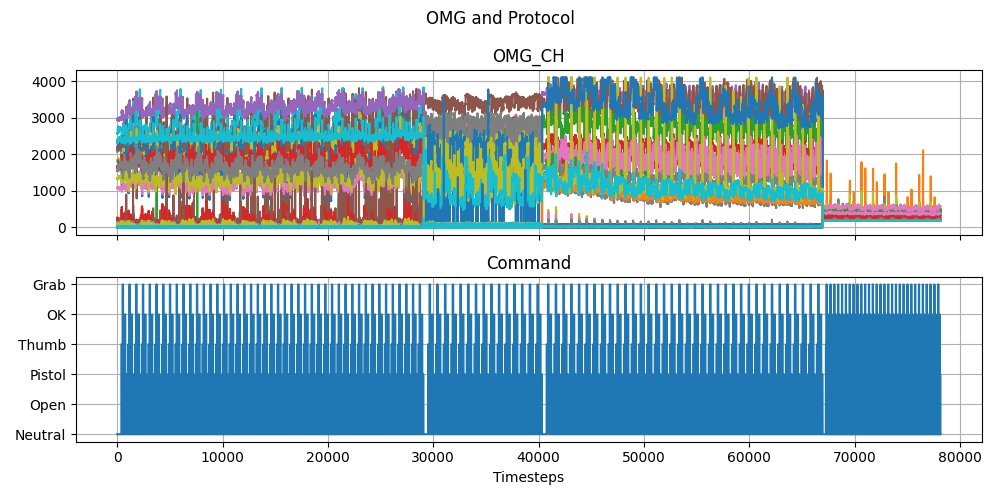

In [112]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.grid()
plt.title('OMG_CH')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.title('Command')
plt.xlabel('Timesteps')
    
plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Data preprocessing

In [113]:
gestures = gestures[ALL_CH]
copy_gestures = gestures.copy()

## OMG_CH

### Features generation

In [114]:
#pd.concat([gestures[OMG_CH].iloc[:,[0]].shift(i).rename(lambda x:str(x)+f'_shift_{i}',axis=1) for i in range(0,4)],axis=1)

In [120]:
def generate_features(df, windows=[5], lags=range(1,20,2), methods_list=None, do_lags=True, skip=False, do_tqdm=False):
    """Генерация признаков методами

    Args:
        df (DataFrame): Входной Dataframe
        windows (list, optional): Список окон для некоторых методов. Defaults to [5].
        lags (list, optional): Список лагов. Defaults to range(1,10).
        methods_list (list, optional): Список применяемых методов, если не указан, то выполнит все. Defaults to None.
        do_lags (bool, optional): Создавать ли лаги. Defaults to True.
        skip (bool, optional): Пропускает этап генерации. Defaults to False.
        do_tqdm (bool, optional): Включить шкалу прогресса. Defaults to False.

    Returns:
        df: Входной + сгенерированные признаки
    """    
    if skip:
        return df
    
    # Методы генерации признаков
    av_methods = { 
        'moving_average': {'func': lambda x, window: x.rolling(window).mean(),'window':True},
        'derivative': {'func': lambda x: x.rolling(5).mean().diff(),'window':False},
        'minus_min': {'func': lambda x: x - x.min(),'window':False},
        #'moving_std': {'func': lambda x, window: x.rolling(window).std(),'window':True},
        #'moving_min': {'func': lambda x, window: x.rolling(window).min(),'window':True},
        #'moving_max': {'func': lambda x, window: x.rolling(window).max(),'window':True},
        'lag_diff': {'func': lambda x: features_df[f'{column}_lag_{lags[0]}'] - features_df[f'{column}_lag_{lags[-1]}'],'window':False},
        #'pct_change': {'func': lambda x: x.pct_change(),'window':False},
    }
    
    methods = {}
    if methods_list == None: # Если список методов пустой, то добавляем все
        methods = av_methods
    elif methods_list == 0: # Пропускаем генерацию признаков
        methods = []
    else: # Иначе добавляем только те что указали
        for method in methods_list:
            methods[method] = av_methods[method]
    
    features_df = pd.DataFrame(index=df.index)
    
    columns = df.columns
    iter = tqdm(columns) if do_tqdm else columns # Выводить ли прогресс цикла
    
    if do_lags: # Создаем признаки лагов
        lags_dict = {} # Словарь сгенерированных признаков по лагам, {column_name : column_data, ...}
        for column in columns:
            for lag in lags:
                lags_dict[f'{column}_lag_{lag}'] = df[column].shift(lag)
        features_df = pd.concat([features_df, pd.DataFrame(lags_dict,index=df.index)],axis=1) # Добавляем лаги в датафрейм
          
    features_dict = {} # Словарь сгенерированных признаков по методам, {column_name : column_data, ...}
    for column in iter: # Создаем признаки по методам
        for method in methods:
            method_info = methods[method]
            if method_info['window']: # Если метод с окном, то применяем метод по всем окнам
                for window in windows:
                    features_dict[f'{column}_{method}_w{window}'] = method_info['func'](df[column],window)
            else: # Иначе если метод без окна, то просто применяем метод
                features_dict[f'{column}_{method}'] = method_info['func'](df[column])
    features_df = pd.concat([features_df, pd.DataFrame(features_dict,index=df.index)],axis=1) # Добавляем признаки в датафрейм
    
    features_df = features_df.bfill().ffill() # Убираем пропуски по краям на ближайшее значение
    features_df = features_df.replace([np.inf,-np.inf],0)
    
    return pd.concat([df,features_df],axis=1)

In [116]:
gestures = generate_features(gestures,do_tqdm=True)
gestures

100%|██████████| 56/56 [00:00<00:00, 62.49it/s]


,0,1,2,3,4,5,6,7,8,9,...,ACC2_lag_diff,GYR0_moving_average_w5,GYR0_derivative,GYR0_lag_diff,GYR1_moving_average_w5,GYR1_derivative,GYR1_lag_diff,GYR2_moving_average_w5,GYR2_derivative,GYR2_lag_diff
0,83,3,4,201,74,2336,16,2074,177,2562,...,1.0,-5.6,0.0,2.0,1.4,0.6,2.0,-6.6,0.6,1.0
1,88,0,2,206,85,2344,22,2076,184,2573,...,1.0,-5.6,0.0,2.0,1.4,0.6,2.0,-6.6,0.6,1.0
2,86,0,1,204,66,2347,26,2084,184,2577,...,1.0,-5.6,0.0,2.0,1.4,0.6,2.0,-6.6,0.6,1.0
3,78,2,0,194,48,2338,12,2077,175,2571,...,1.0,-5.6,0.0,2.0,1.4,0.6,2.0,-6.6,0.6,1.0
4,89,1,4,206,70,2346,22,2084,184,2572,...,1.0,-5.6,0.0,2.0,1.4,0.6,2.0,-6.6,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11163,429,341,178,178,178,179,177,178,237,421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11164,418,341,179,179,178,179,178,178,239,407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11165,405,336,178,178,178,178,177,178,235,392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11166,389,331,178,178,178,179,178,178,231,377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Protocol

In [117]:
def constant_shift(y,offset=22):
    '''Смещение всего целевого признака на константное значение'''
    return np.concatenate((np.full(offset, 0), y[:-offset]))

def deriv_max_shift(X,y, min_window=5, max_window=27):
    '''Смещение изменений целевого признака по скачку производных'''
    X = X.copy().reset_index()
    new_y = y.copy()
    id_max = 1
    OMG_DERIV = [*X.filter(X.columns.map(lambda s: s if 'derivative' in s else None),axis=1).columns]
    X['deriv_abs_sum'] = X[OMG_DERIV].abs().sum(axis=1)
    for i in range(y.shape[0]):
        if i < id_max: # Пропускаем все значения до id_max
            continue
        if y[i] != y[i-1]: # Если сменился жест то ищем в данных спереди максимальный скачок
            id_max = X['deriv_abs_sum'][i+min_window:i+max_window].idxmax() # модуль производных -> сумма всех датчиков -> айди максимального значения
            new_y[i:id_max] = y[i-1] # Заменяем все значения до id_max на предыдущий жест
    return new_y

In [118]:
OMG_DERIV = [*gestures.filter(gestures.columns.map(lambda s: s if 'derivative' in s else None),axis=1).columns]
y_berofe_shift = y_cmd.copy()
y_cmd = deriv_max_shift(gestures,y_cmd)

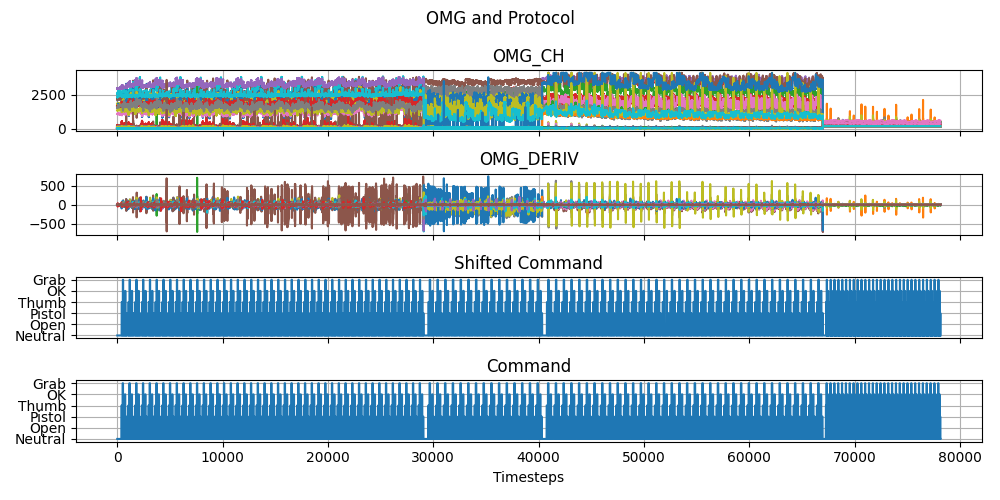

In [119]:
# График показаний датчиков
fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 5))

plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.grid()
plt.title('OMG_CH')

plt.sca(axx[1])
plt.plot(gestures[OMG_DERIV].values)
plt.grid()
plt.title('OMG_DERIV')

plt.sca(axx[2])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.title('Shifted Command')
    
plt.sca(axx[3])
plt.plot(y_berofe_shift)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.title('Command')
plt.xlabel('Timesteps')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [163]:
# backup
if 0:
    y_cmd = y_berofe_shift.copy()
    #gestures = copy_gestures.copy()

## Features dropout

In [126]:
def dropout_features(df, y, target='command', weak_edge=0.02, strong_edge=0.95, skip=False, skip_weak=False):
    """Отсеивание признаков по корреляции

    Args:
        df (Dataframe): Входной Dataframe
        target (str, optional): Целевой признак. Defaults to 'command'.
        weak_edge (float, optional): Отсев по слабой корреляции с целевым признаком. Defaults to 0.02.
        strong_edge (float, optional): Отсев по сильной корреляции между собой. Defaults to 0.95.
        skip (bool, optional): Пропуск этапа отсеивания. Defaults to False.

    Returns:
        df: Очищенный от признаков Dataframe
    """    
    df = df.copy()
    if skip:
        return df
    
    drop_weak, drop_strong = [], []
    
    if not skip_weak:
        df[target] = y
        corr_df = pd.DataFrame(np.absolute(np.corrcoef(df.values, rowvar=False)), columns=df.columns)
        # Отсев по слабой корреляции признаков с таргетом
        drop_weak = list(corr_df[corr_df <= weak_edge].T.iloc[:-1,-1].dropna().index)
        #print(f'Drop weak: {drop_weak.__len__()}')
    else:
        corr_df = pd.DataFrame(np.absolute(np.corrcoef(df.values, rowvar=False)), columns=df.columns)
    
    # Отсев по сильной корреляции признаков между собой
    upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    drop_strong = [column for column in upper.columns if any(upper[column] > strong_edge) and column != target]
    #print(f'Drop strong: {drop_strong.__len__()}')
    
    if skip_weak:
        df = df.drop(list(set(drop_weak+drop_strong)),axis=1)
    else:
        df = df.drop(list(set(drop_weak+drop_strong))+[target],axis=1)
    #print(f'Remained features: {df.columns.__len__()}')
    return df

In [165]:
gestures = dropout_features(gestures, y_cmd)

# Train-test split

In [125]:
def data_split(X,y, palm_files=None, test_datasets=[0], split_type=None, pilote_id=1):
    X = X.copy()
    y = y.copy()
    X = [*X.values]
    y = [*y]
    if palm_files.__len__() == 1: # Если palm_files один то разделяем 1 датасет по индексу
        # Узнаем последний индекс обучающей выборки для нужного файла
        last_train_idx = df_meta[df_meta['montage'] == palm_files[0].split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
        # Разделяем данные на обучающую и тестовую по индексу полученному с /data/meta_information.csv
        X_train = X[:last_train_idx]
        y_train = y[:last_train_idx]
        X_test = X[last_train_idx:]
        y_test = y[last_train_idx:]
        # Заменяем списки на numpy массивы
        X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    elif palm_files.__len__() > 1: # Если palm_files не один, то разделяем склееные датасеты на части Пример(3 датасета обучающих, 2 тестовых)
        if split_type == 'pilote_id': # Если делим по пилоту, то добавляем индексы файлов конкретного пилота в test_datasets
            test_datasets=[]
            for i, palm_file in enumerate(palm_files):
                if palm_file[7:] in df_meta[df_meta['pilote_id'] == pilote_id]['montage'].values:
                    test_datasets.append(i)
        
        end_idx = 0
        X_train, y_train, X_test, y_test = [], [], [], []
        for i, palm_file in enumerate(palm_files): # цикл по файлам
            len_palm_file = df_meta[df_meta['montage'] == palm_file[7:]][['len(train)','len(test)']].sum(axis=1).iloc[0] # Длина текущего файла
            start_idx = end_idx # индекс старта файла
            end_idx = start_idx + len_palm_file # индекс конца
            if i in test_datasets: # если текущий файл тестовый
                X_test = X_test + X[start_idx:end_idx]
                y_test = y_test + y[start_idx:end_idx]
            else: # иначе файл обучающий
                X_train = X_train + X[start_idx:end_idx]
                y_train = y_train + y[start_idx:end_idx]
        # Заменяем списки на numpy массивы
        X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    return X_train, y_train, X_test, y_test

In [167]:
X_train, y_train, X_test, y_test = data_split(gestures, y_cmd, palm_files=palm_files)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(49057, 182) (49057,)
(29092, 182) (29092,)


# Pipeline

In [124]:
# Пайплайн
def preprocess_X(X,y,skip_generate=False,skip_dropout=False, windows=[5], lags=range(1,10), methods_list=None, weak_edge=0.02, strong_edge=0.95,skip_weak=False):
    '''Предобработка факторов, генерация новых признаков -> очистка по корреляции'''
    OMG_CH = [str(i) for i in range(50)]
    ALL_CH = OMG_CH + ['ACC0', 'ACC1', 'ACC2'] + ['GYR0', 'GYR1', 'GYR2']
    X = X[ALL_CH]
    
    X = generate_features(X, skip=skip_generate, windows=windows, lags=lags, methods_list=methods_list)
    
    X = dropout_features(X, y, skip=skip_dropout, weak_edge=weak_edge, strong_edge=strong_edge,skip_weak=skip_weak)
    
    return X

def preprocess_y(X,y,offset_type='deriv_max',window=35,offset=22):
    '''Предобработка целевого признака, декодирование -> расширение -> смещение'''
    y = y.copy()
    X = X.copy()
    OMG_CH = [str(i) for i in range(50)]
    
    y = encode_y(y) # Кодируем 10 признаков в 1
    
    y = np.array([y['gesture'].iloc[s] for s in X['SYNC'].values]).flatten() # Расширяем признак
    
    if offset_type == 'deriv_max': # Если тип смещения по максимальное производной
        X = generate_features(X[OMG_CH],do_lags=False,methods_list=['derivative']) # Генерируем производные для смещения
        y = deriv_max_shift(X,y) # Смещение
    elif offset_type == 'constant': # Если тип смещения на константу
        y = constant_shift(y,offset=offset) # Смещение
    elif offset_type == 'skip': # Если пропускаем этап смещения
        pass
    
    return y

def smart_score(model,X,y):
    '''Оценка модели с учётом дисбаланса классов'''
    y_pred = model.predict(X)
    return f1_score(y,y_pred,average='weighted')

def leave_one_out_score(model,X,y,palm_files, split_type='loo'):
    '''Leave one out оценка модели, разбиение по датасетам palm_file'''
    score_list = np.array([])
    
    if split_type == 'pilote_id': # Если делим по пилотам
        pilots_list = [*df_meta[df_meta['montage'].isin([palm_file[7:] for palm_file in palm_files])]['pilote_id'].unique()]
        for i,pilote in enumerate(pilots_list): # Цикл по всем пилотам
            print(f'loo {i+1} / {pilots_list.__len__()}') # Прогресс
            # Разделяем данные и как тестовый указываем данные текущего пилота
            X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_files, split_type='pilote_id',pilote_id=pilote)
            model.fit(X_train, y_train)  # Обучаем модель
            score = smart_score(model,X=X_test,y=y_test) # Оцениваем модель
            score_list = np.append(score_list,score) # Добавляем оценку в список
            
    elif split_type == 'loo': # Если делим по leave one out методу
        for i, palm_file in enumerate(palm_files): # Цикл по всем датасетам
            #print(f'{i+1} / {palm_files.__len__()}') # Прогресс
            # Разделяем данные и как тестовый указываем текущий
            X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_files, test_datasets=[i])
            model.fit(X_train, y_train)  # Обучаем модель
            score = smart_score(model,X=X_test,y=y_test) # Оцениваем модель
            score_list = np.append(score_list,score) # Добавляем оценку в список
            
    return score_list

# Data quality

In [169]:
# Смотрим на качество датасетов
''' 
d = {}
for i, palm_file in tqdm(enumerate(palms_list)):
    y = read_y(palm_file)
    X = read_X(palm_file)
    y = preprocess_y(X,y)
    X = preprocess_X(X,skip_generate=True,skip_dropout=True)
    
    X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_file)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Создаем модель
    model = LogisticRegression(
        solver='lbfgs', 
        max_iter=3000
    )
    # Обучаем модель
    model.fit(X_train, y_train)
    # Оцениваем модель
    score = smart_score(model,X=X_test,y=y_test)
    d[i] = (score, palm_file)
pd.DataFrame(d.values(),index=d.keys(),columns=['F1_score','palm_file']).sort_values(by='F1_score')
'''

" \nd = {}\nfor i, palm_file in tqdm(enumerate(palms_list)):\n    y = read_y(palm_file)\n    X = read_X(palm_file)\n    y = preprocess_y(X,y)\n    X = preprocess_X(X,skip_generate=True,skip_dropout=True)\n    \n    X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_file)\n    \n    scaler = MinMaxScaler()\n    X_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n    # Создаем модель\n    model = LogisticRegression(\n        solver='lbfgs', \n        max_iter=3000\n    )\n    # Обучаем модель\n    model.fit(X_train, y_train)\n    # Оцениваем модель\n    score = smart_score(model,X=X_test,y=y_test)\n    d[i] = (score, palm_file)\npd.DataFrame(d.values(),index=d.keys(),columns=['F1_score','palm_file']).sort_values(by='F1_score')\n"

# Validate offset method

In [170]:
''' 
y = read_y(palm_file)
X = read_X(palm_file)
print('preprocess')
y_original = preprocess_y(X,y,offset_type='skip')
y_constant = preprocess_y(X,y,offset_type='constant',offset=20)
y_deriv_max = preprocess_y(X,y,offset_type='deriv_max')
X = preprocess_X(X,y,skip_weak=True)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

model_original = LogisticRegression(max_iter=1000, n_jobs=-1)
model_constant = LogisticRegression(max_iter=1000, n_jobs=-1)
model_deriv_max = LogisticRegression(max_iter=1000, n_jobs=-1)
print('split')
X_train, y_train_original, X_test, y_test_original = data_split(X, y_original, palm_files=palm_file)
X_train, y_train_constant, X_test, y_test_constant = data_split(X, y_constant, palm_files=palm_file)
X_train, y_train_deriv_max, X_test, y_test_deriv_max = data_split(X, y_deriv_max, palm_files=palm_file)
print('model fit')
model_original.fit(X_train,y_train_original)
model_constant.fit(X_train,y_train_constant)
model_deriv_max.fit(X_train,y_train_deriv_max)
'''

" \ny = read_y(palm_file)\nX = read_X(palm_file)\nprint('preprocess')\ny_original = preprocess_y(X,y,offset_type='skip')\ny_constant = preprocess_y(X,y,offset_type='constant',offset=20)\ny_deriv_max = preprocess_y(X,y,offset_type='deriv_max')\nX = preprocess_X(X,y,skip_weak=True)\n\nscaler = MinMaxScaler()\nX = scaler.fit_transform(X)\n\nmodel_original = LogisticRegression(max_iter=1000, n_jobs=-1)\nmodel_constant = LogisticRegression(max_iter=1000, n_jobs=-1)\nmodel_deriv_max = LogisticRegression(max_iter=1000, n_jobs=-1)\nprint('split')\nX_train, y_train_original, X_test, y_test_original = data_split(X, y_original, palm_files=palm_file)\nX_train, y_train_constant, X_test, y_test_constant = data_split(X, y_constant, palm_files=palm_file)\nX_train, y_train_deriv_max, X_test, y_test_deriv_max = data_split(X, y_deriv_max, palm_files=palm_file)\nprint('model fit')\nmodel_original.fit(X_train,y_train_original)\nmodel_constant.fit(X_train,y_train_constant)\nmodel_deriv_max.fit(X_train,y_tra

In [171]:
'''
models_dict = {'Original':model_original,
               'Constant':model_constant,
               'Deriv_max':model_deriv_max}
y_test_list = [y_test_original,y_test_constant,y_test_deriv_max]

df_list = []

for i in range(6):
    d = {}
    for model_type in models_dict:
        score_list = []
        for y_test in y_test_list:
            model = models_dict[model_type]
            y_pred = model.predict(X_test)
            score = np.round(f1_score(y_test,y_pred,average=None)[i],2)
            score_list.append(score)
        d['model_'+model_type] = score_list
    df_list.append(pd.DataFrame(d,index=['y_original','y_constant','y_deriv_max'])) 
d = {}
for model_type in models_dict:
    score_list = []
    for y_test in y_test_list:
        model = models_dict[model_type]
        y_pred = model.predict(X_test)
        score = np.round(f1_score(y_test,y_pred,average='weighted'),2)
        score_list.append(score)
    d['model_'+model_type] = score_list
df_weighted = pd.DataFrame(d,index=['y_original','y_constant','y_deriv_max']) 

print(2*'='+f' Weighted '+49*'=')
print(df_weighted)
for i in range(6):
    print(2*'='+f' Class {i} '+50*'=')
    print(df_list[i])
'''

"\nmodels_dict = {'Original':model_original,\n               'Constant':model_constant,\n               'Deriv_max':model_deriv_max}\ny_test_list = [y_test_original,y_test_constant,y_test_deriv_max]\n\ndf_list = []\n\nfor i in range(6):\n    d = {}\n    for model_type in models_dict:\n        score_list = []\n        for y_test in y_test_list:\n            model = models_dict[model_type]\n            y_pred = model.predict(X_test)\n            score = np.round(f1_score(y_test,y_pred,average=None)[i],2)\n            score_list.append(score)\n        d['model_'+model_type] = score_list\n    df_list.append(pd.DataFrame(d,index=['y_original','y_constant','y_deriv_max'])) \nd = {}\nfor model_type in models_dict:\n    score_list = []\n    for y_test in y_test_list:\n        model = models_dict[model_type]\n        y_pred = model.predict(X_test)\n        score = np.round(f1_score(y_test,y_pred,average='weighted'),2)\n        score_list.append(score)\n    d['model_'+model_type] = score_list\nd

# Modeling

In [130]:
palm_files = get_palm_files(get_type='all',var=2)[9:10]
palm_files

['./data/2023-05-22_17-04-29.palm']

In [131]:
df_meta[df_meta['montage'].isin([s[7:] for s in palm_files])]

,montage,pilote_id,last_train_idx,len(train),len(test)
16,2023-05-22_17-04-29.palm,2,23289,23289,5796


In [132]:
y = read_y(palm_files)
X = read_X(palm_files)
#y_orig = preprocess_y(X,y,offset_type='skip')
y = preprocess_y(X,y,offset_type='deriv_max')
X = preprocess_X(X,y,skip_generate=0,skip_dropout=0,skip_weak=1)
ALL_COLS = X.columns
X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_files)
#X_train, y_train_orig, X_test, y_test_orig = data_split(X, y_orig, palm_files=palm_files)

## Optuna search

In [101]:
if DO_OPTUNA_SEARCH:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    def objective(trial): 
        global X, y
        trial.set_user_attr("Palm files", palm_files.__len__())
        # Задаем пространства поиска гиперпараметров
        
        # Предобработка данных с учетом гиперпараметров
        if True:
            y = preprocess_y(X_for_prepr, y_for_prepr,offset_type='constant')
            X = preprocess_X(X_for_prepr, y)
            print('preprocess+')
        
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        
        # Создаем модель
        model = LogisticRegression(
        max_iter=100,
        n_jobs=-1,
        )
        
        trial.set_user_attr("model", model.__str__())
        trial.set_user_attr("params", model.get_params())
        
        # Оценка модели
        if True: # Оценка кросс валидацией
            score_list = leave_one_out_score(model,X,y,palm_files,split_type='pilote_id')
            score = score_list.mean()
            trial.set_user_attr("LOO score list", str(score_list))
            print('loo+')
            if False:
                const_score_list = leave_one_out_score(model,X,y_const_shifted,palm_files,split_type='')
                const_score = const_score_list.mean()
                trial.set_user_attr("LOO const score list", str(const_score_list))
                trial.set_user_attr("LOO const score", const_score)
                print('looConst+')
        else: # Иначе просто оцениваем модель
            X_train, y_train, X_test, y_test = data_split(X, y, palm_files=palm_files, test_datasets=[0])
            model.fit(X_train,y_train)
            score = smart_score(model,X_test,y_test)
        
        return score
    
    # Загружаем данные для предобработки в подборе гиперпараметров
    if True: # Загружаем данные для предобработки заранее чтобы меньше нагружать в optune
        X_for_prepr = read_X(palm_files)
        y_for_prepr = read_y(palm_files)
        y_const_shifted = y_for_prepr.copy()
        y_const_shifted = preprocess_y(X_for_prepr,y_const_shifted,offset_type='constant')
        
    # Создаем объект исследования
    study = optuna.create_study(study_name="AllData/looPilots/yderiv&yconstant", storage="sqlite:///optuna_dashboard.sqlite3", direction="maximize")

    # Ищем лучшую комбинацию гиперпараметров:
    study.optimize(objective, n_trials=1, timeout=300, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

preprocess+
loo 1 / 4
data_split 1 / 17
data_split 2 / 17
data_split 3 / 17
data_split 4 / 17
data_split 5 / 17
data_split 6 / 17
data_split 7 / 17
data_split 8 / 17
data_split 9 / 17
data_split 10 / 17
data_split 11 / 17
data_split 12 / 17
data_split 13 / 17
data_split 14 / 17
data_split 15 / 17
data_split 16 / 17
data_split 17 / 17
loo 2 / 4
data_split 1 / 17
data_split 2 / 17
data_split 3 / 17
data_split 4 / 17
data_split 5 / 17
data_split 6 / 17
data_split 7 / 17
data_split 8 / 17
data_split 9 / 17
data_split 10 / 17
data_split 11 / 17
data_split 12 / 17
data_split 13 / 17
data_split 14 / 17
data_split 15 / 17
data_split 16 / 17
data_split 17 / 17
loo 3 / 4
data_split 1 / 17
data_split 2 / 17
data_split 3 / 17
data_split 4 / 17
data_split 5 / 17
data_split 6 / 17
data_split 7 / 17
data_split 8 / 17
data_split 9 / 17
data_split 10 / 17
data_split 11 / 17
data_split 12 / 17
data_split 13 / 17
data_split 14 / 17
data_split 15 / 17
data_split 16 / 17
data_split 17 / 17
loo 4 / 4
data_s

In [100]:
#optuna.delete_study(study_name='AllData/looPilots/yderiv&yconstant',storage="sqlite:///optuna_dashboard.sqlite3",)

In [169]:
study.best_params

{'offset_type': 'deriv_max', 'offset': 20}

In [170]:
if DO_OPTUNA_SEARCH:
    param_importances = optuna.visualization.plot_param_importances(study)
    param_importances.show()

In [171]:
if DO_OPTUNA_SEARCH:
    parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study)
    parallel_coordinate.show()

## Model

In [133]:
# Создаем итоговую модель
model = LogisticRegression(max_iter=1000,class_weight={0: 1, 1: 2, 2: 2, 3: 3, 4: 2, 5: 2})

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model.fit(X=X_train_s, y=y_train)

c:\Users\Gera\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 2, 2: 2, 3: 3, 4: 2, 5: 2},
                   max_iter=1000)

In [134]:
y_pred_train = model.predict(X_train_s)
y_pred_test = model.predict(X_test_s)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     16388
           1       0.98      0.99      0.98      1398
           2       0.97      1.00      0.98      1404
           3       0.94      0.98      0.96      1409
           4       0.96      0.97      0.97      1337
           5       0.95      0.97      0.96      1353

    accuracy                           0.98     23289
   macro avg       0.97      0.98      0.97     23289
weighted avg       0.98      0.98      0.98     23289

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4114
           1       0.98      0.93      0.95       334
           2       0.99      0.77      0.86       364
           3       0.94      0.95      0.94       335
           4       0.89      0.96      0.93       313
           5       0.96      0.83      0.89       334

    accuracy                           0.95      5794
   macro avg       0.95

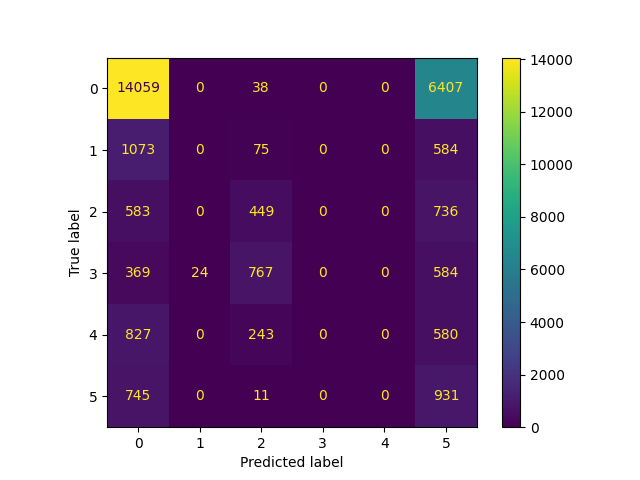

In [202]:
draw_confusion_matrix(model,X_test_s,y_test)

In [232]:
# Функция построения графика кривой обучения
def plot_learning_curve(model, X, y, cv=4, scoring="f1_micro"):
    # Вычисляем координаты для построения кривой обучения
    skf = StratifiedKFold(n_splits=cv, shuffle=True) # кросс валидация
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=skf, # кросс валидатор
        scoring=scoring,  # метрика
        train_sizes=np.linspace(0.05,1,10), # Кол-во разбиений
    )
    display = LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=valid_scores,score_name=scoring)
    display.plot()
    plt.title('Learning Curve')
    plt.yticks(np.arange(0,1.05,0.05))
    plt.grid()
    plt.show()
    return display
if DO_PLOT_LEARNING_CURVE:
    learn_curve_plot = plot_learning_curve(model,X_train,y_train)

## Prediction

In [233]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

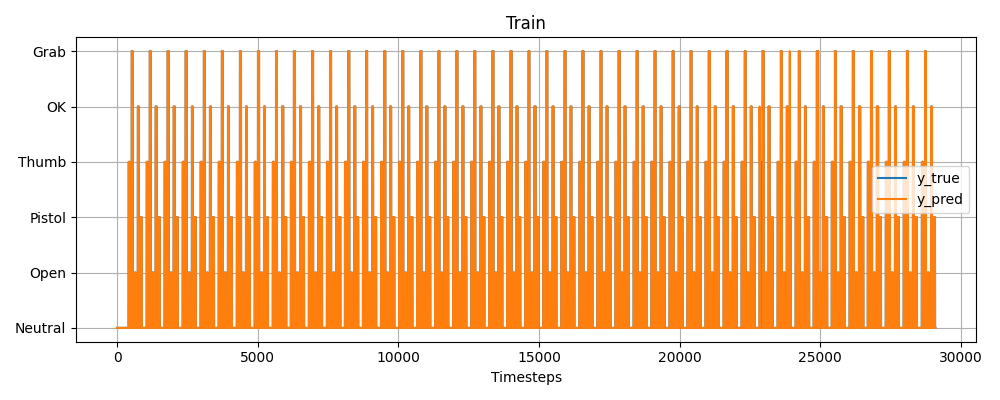

In [190]:
if 1:
    # График истинных и предсказанных значений таргета в тренировочных данных
    fig = plt.figure(figsize=(10, 4))
    plt.plot(y_train,  c='C0', label='y_true')
    plt.plot(y_pred_train, c='C1', label='y_pred')
    
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title('Train')
    plt.tight_layout()

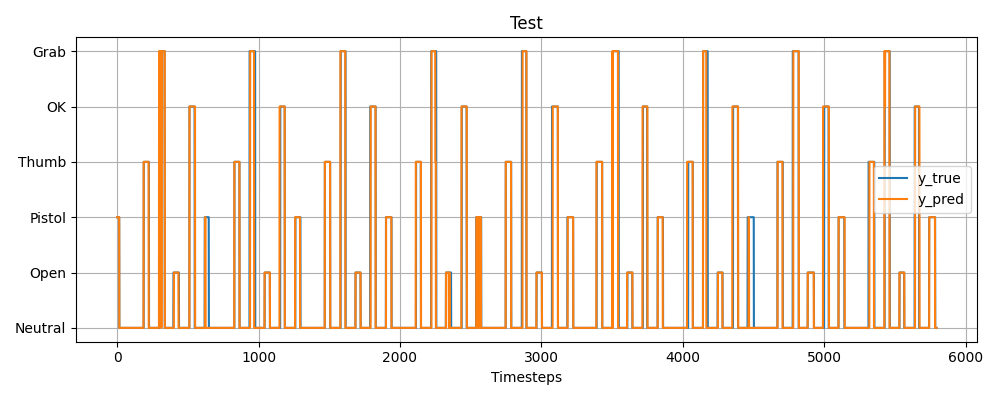

In [135]:
if 1:
    # График истинных и предсказанных значений таргета в тестовых данных
    fig = plt.figure(figsize=(10, 4))
    plt.plot(y_test,  c='C0', label='y_true')
    plt.plot(y_pred_test, c='C1', label='y_pred')
    
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title('Test')
    plt.tight_layout()

## Metrics

In [236]:
print_report()

========================= Train =========================
              precision    recall  f1-score   support

     Neutral       0.98      0.96      0.97     10615
        Open       0.98      0.94      0.96       987
      Pistol       0.95      0.91      0.93       933
       Thumb       0.71      0.99      0.82      1011
          OK       0.97      0.85      0.91      1057
        Grab       0.99      1.00      0.99      1076

    accuracy                           0.95     15679
   macro avg       0.93      0.94      0.93     15679
weighted avg       0.96      0.95      0.96     15679

========================= Test =========================
              precision    recall  f1-score   support

     Neutral       0.97      0.92      0.94      2593
        Open       0.96      0.90      0.93       251
      Pistol       0.88      0.96      0.92       277
       Thumb       0.65      0.84      0.73       262
          OK       0.71      0.95      0.81       239
        Grab     

# Real-time inference

In [64]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [119]:
def preprocessing(x,cols): # Предобработка входных данных
    # x - sample vector
    x = pd.DataFrame(x,ALL_CH).T
    x = preprocess_X(x,y=None,skip_dropout=True)
    display(x)
    x = x[cols]
    y = x.values
    return y

def inference(x): # Предикт модели на данных
    y = model.predict([x])
    return y

def postprocessing(x, prev): # Постобработка результатов модели, сглаживаем с предыдущим предиктом
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [94]:
if DO_OFFLINE_INFERENCE:
    df_sim = read_X(palm_files)
    X_ds, y_ds, df_sim, y_ds = data_split(df_sim, y, palm_files=palm_files)
    df_sim = pd.DataFrame(df_sim,columns=ALL_CH+ENC_CH+BUTTON_SYNC_TS_CH)
    del X_ds, y_ds
    #df_sim = gestures.iloc[last_train_idx:]
    print(df_sim.shape)

(5507, 65)


In [97]:
sample = df_sim.values[i]
[omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
all_sample = np.concatenate([omg_sample,acc_sample])
all_sample
pd.DataFrame(all_sample,columns=ALL_CH)

ValueError: Shape of passed values is (56, 1), indices imply (56, 56)

In [120]:
if DO_OFFLINE_INFERENCE:
    TIMEOUT = 0.033
    DEBUG = False

    i = 0
    ts_old = time.time()
    ts_diff = 0;
    ts_list = []

    y_previous = None
    y_dct = {
        'omg_sample':[],
        'enc_sample':[],
        'sample_preprocessed':[],

        'y_predicted':[],
        'y_postprocessed':[],
        'y_commands':[],
    }
    while True:    

        # [Data reading]
        ts_start = time.time()

        try:
            # [Sim data]
            if i < len(df_sim):
                sample = df_sim.values[i]
            else:
                break
            # [/Sim data]
            [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
            all_sample = np.concatenate([omg_sample,acc_sample])
            all_sample

        except Exception as e:
            print(e)
        # [/Data Reading]

        # [Data preprocessing]
        sample_preprocessed = preprocessing(all_sample,ALL_COLS)
        # [/Data preprocessing]

        # [Inference]
        y_predicted         = inference(sample_preprocessed)
        # [/Inference]

        # [Inference Postprocessing]
        y_postprocessed     = postprocessing(y_predicted, y_previous)
        # [/Inference Postprocessing]

        # [Commands composition]
        y_commands          = commands(y_postprocessed)
        # [/Commands composition]

        # [Commands sending]
        # NO COMMANDS SENDING IN SIMULATION
        # [/Commands sending]

        # [Data logging]
        y_dct['omg_sample'].append(omg_sample)
        y_dct['acc_sample'].append(acc_sample)
        y_dct['sample_preprocessed'].append(sample_preprocessed)
        y_dct['y_predicted'].append(y_predicted)
        y_dct['y_postprocessed'].append(y_postprocessed)
        y_dct['y_commands'].append(y_commands)
        # [/Data logging]

        y_previous = y_postprocessed

        if DEBUG:
            clear_output(wait=True)

            # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
            print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
            print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
            print(y_commands)

        # Считаем время выполнение инференса
        ts_diff = time.time() - ts_start

        ts_list.append(ts_diff)
        ts_old = ts_start
        i += 1 

    ts_mean = np.array(ts_list).mean()
    ts_max = np.array(ts_list).max()
    if ts_max > TIMEOUT:
        print('Calculation cycle takes more than TIMEOUT')
    print(f'Timeout: {TIMEOUT}')
    print(f'   mean: {round(ts_mean,5)}')
    print(f'    max: {round(ts_max,5)}')

,0,1,2,3,4,5,6,7,8,9,...,GYR0_moving_std_w5,GYR0_lag_diff,GYR1_moving_average_w5,GYR1_derivative,GYR1_moving_std_w5,GYR1_lag_diff,GYR2_moving_average_w5,GYR2_derivative,GYR2_moving_std_w5,GYR2_lag_diff
0,66,99,2,226,96,7,37,2658,186,3464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: Found array with dim 3. LogisticRegression expected <= 2.

In [241]:
if DO_OFFLINE_INFERENCE:
    for key, val in y_dct.items():
        # print(f"len({key}) = {len(y_dct[key])}")
        y_dct[key] = np.stack(val)
        print(f"{key}.shape = {y_dct[key].shape}")

In [242]:
if DO_OFFLINE_INFERENCE and DO_DRAW_PLOTS:
    fig = plt.figure(figsize=(10, 3))
    
    plt.plot(y_test, c='C0', label='y_cmd')
    plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
    plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
    plt.plot(y_dct['y_commands'], c='C3', label='y_commands')
    
    plt.title('Ground truth vs predicted vs postprocessed vs commands')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.legend()
    plt.grid()
    plt.xlabel('Timesteps')
    
    plt.tight_layout()

In [243]:
if DO_OFFLINE_INFERENCE:
    print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

### Online (prosthesis or virtual hand)

In [244]:
if DO_ONLINE_INFERENCE:
    TIMEOUT = 0.033
    DEBUG = True
    
    ser = None
    # ser_port = None
    # ser_port = '/dev/ttyACM0'
    ser_port = '/dev/cu.usbmodem3498365F31351'
    
    if ser_port is not None:
        ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
        ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
        ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
        ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check
    
        # flush buffers
        ser.reset_input_buffer()
        ser.read()
        
        i = 0;
        while(ser.in_waiting):
            print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
            ser.read_all()
            time.sleep(0.005)
            i+=1;
        ser.readline()
        ser.readline()
        
    i = 0
    ts_old = time.time()
    ts_diff = 0;
    
    y_previous = None
    while True:    
        
        # [Data reading]
        s = ser.readline()
        ts_start = time.time()
        
        try:
            sample = np.array(s.decode('UTF-8')\
                               .replace('\r\n', "")\
                               .split(' ')
                             ).astype(int)
            [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
            
        except Exception as e:
            print(e)
            
        # [/Data Reading]
            
        # [Data preprocessing]
        sample_preprocessed = preprocessing(omg_sample)
        # [/Data preprocessing]
        
        # [Inference]
        y_predicted         = inference(sample_preprocessed)
        # [/Inference]
        
        # [Inference Postprocessing]
        y_postprocessed     = postprocessing(y_predicted, y_previous)
        # [/Inference Postprocessing]
        
        # [Commands composition]
        y_commands          = commands(y_postprocessed)
        # [/Commands composition]
        
        # [Commands sending]
        pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
        # [/Commands sending]
        
        y_previous = y_postprocessed
        
        if DEBUG:
            clear_output(wait=True)
    
            # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
            print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
            print('INPUT:\n', s)
    
            # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
            print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
            print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
            print(y_commands)
            print(pack)
        
        ts_diff = time.time() - ts_start
        assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
        ts_old = ts_start
        i += 1 

# Log into comet.ml

In [245]:
if DO_LOG:
    from comet_ml import Experiment
    # Создаем эксперимент у пользователя WORKSPACE в проекте PROJECT_NAME используя ключ API_KEY
    exp = Experiment(
        api_key=API_KEY,
        project_name=PROJECT_NAME,
        workspace=WORKSPACE,
    )
    try: exp.set_name(type(model).__name__)
    except:pass
    
    # Модель
    try: exp.log_text(text=type(model).__name__)
    except:pass
    # Параметеры
    try: exp.log_parameters(model.get_params())
    except:pass
    try: exp.log_parameters(best,prefix='best_')
    except:pass
    # Метрики
    train_metrics = f1_score(y_train, y_pred_train, average='micro')
    try: exp.log_metric(name='train',value=train_metrics)
    except:pass
    test_metrics = f1_score(y_test, y_pred_test, average='micro')
    try: exp.log_metric(name='test',value=test_metrics)
    except:pass
    # Время
    try: exp.log_metric(name='ts_mean',value=ts_mean)
    except:pass
    try: exp.log_metric(name='ts_max',value=ts_max)
    except:pass
    # График кривой обучения
    learn_curve_plot.plot()
    plt.title('Learning Curve')
    plt.yticks(np.arange(0,1.05,0.05))
    plt.grid()
    try: exp.log_figure(figure=plt)
    except:pass
    # Матрица ошибок
    try: exp.log_confusion_matrix(y_train.tolist(), y_pred_train.tolist())
    except:pass
    try: exp.log_confusion_matrix(y_test.tolist(), y_pred_test.tolist())
    except:pass
    
    exp.display()
    exp.end()